# S&P 100 - Fama French 5 Factor Model

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

datadir='../../data/'

sigmas=pd.read_csv(datadir+'ff_sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'ff_returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'ff_volumes.csv.gz',index_col=0,parse_dates=[0])

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2016-04-01"
end_t="2018-12-31"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')

estimate_data = pd.HDFStore(datadir+'ff_model.h5')

optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1.,
                                   sigma=estimate_data.sigma_estimate,
                                   volume=estimate_data.volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

risk_model = cp.FactorModelSigma(estimate_data.exposures, estimate_data.factor_sigma, estimate_data.idyos)

results={}

# SPO Pareto search 

In [3]:
results_pareto={}

### Sparse Pareto

In [4]:
policies={}
gamma_risks_pareto=[1, 10, 100, 500]
gamma_tcosts_pareto=[5, 10, 15, 20]
gamma_holdings=[1, 100]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = \
          cp.SinglePeriodOpt(estimate_data.return_estimate,
                             [gamma_risk*risk_model,gamma_tcost*optimization_tcost,\
                                       gamma_holding*optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(),
                               simulator.run_multiple_backtest(1E8*w_b, start_time=start_t, end_time=end_t,
                                                               policies=policies.values(), parallel=True))))

In [5]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'ff_spo_pareto_results.csv', float_format='%g')
table.style.format({'Return': "{:.2%}", 'Risk': '{:.2%}'})

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk,is_pareto
0,1,5,100,66.86%,58.15%,True
1,1,10,100,48.40%,56.33%,False
2,1,5,1,52.52%,50.04%,True
3,1,15,100,33.79%,43.40%,False
4,1,10,1,38.19%,41.11%,True
5,1,15,1,32.24%,33.29%,True
6,10,5,100,26.72%,30.12%,True
7,1,20,100,18.32%,29.93%,False
8,10,5,1,1.82%,26.39%,False
9,1,20,1,22.25%,25.40%,False


## Efficient Frontier

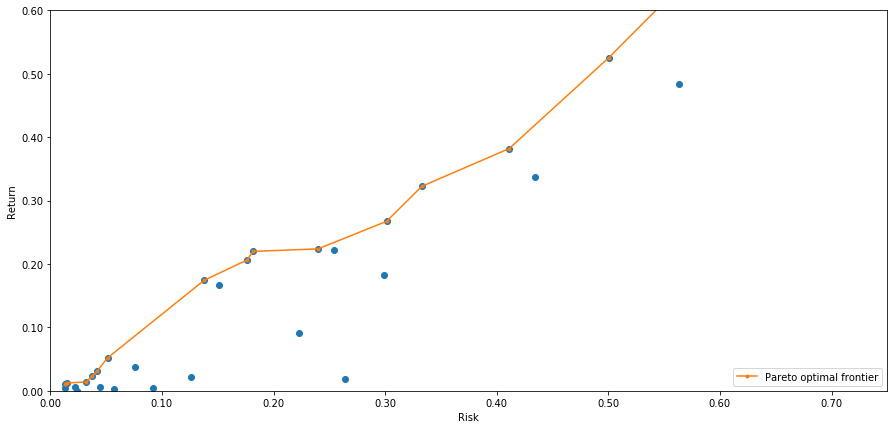

In [6]:
plt.figure(figsize=(15,7))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,0.75])
plt.ylim([0,0.6])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

plt.savefig('ff_spo_pareto.png')

In [7]:
xlim=30
ylim=60
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.style.format({'Return': "{:.2%}", 'Risk': '{:.2%}'})

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk
0,1,5,100,66.86%,58.15%
2,1,5,1,52.52%,50.04%
4,1,10,1,38.19%,41.11%
5,1,15,1,32.24%,33.29%
6,10,5,100,26.72%,30.12%
10,10,10,100,22.38%,23.99%
12,10,15,100,21.98%,18.18%
13,10,15,1,20.61%,17.60%
15,10,20,1,17.41%,13.78%
21,100,10,100,5.21%,5.14%
